**SOFT DEADLINE:** `20.03.2022 23:59 msk` 

Student: Nemat Allah Aloush 

Group number : J41332c

ISU number : 336092

# [5 points] Part 1. Data cleaning

The task is to clear the text data of the crawled web-pages from different sites. 

It is necessary to ensure that the distribution of the 100 most frequent words includes only meaningful words in english language (not particles, conjunctions, prepositions, numbers, tags, symbols).

Determine the order of operations below and carry out the appropriate cleaning.

1. Remove non-english words
1. Remove html-tags (try to do it with regular expression, or play with beautifulsoap library)
1. Apply lemmatization / stemming
1. Remove stop-words
1. Additional processing - At your own initiative, if this helps to obtain a better distribution

#### Hints

1. To do text processing you may use nltk and re libraries
1. and / or any other libraries on your choise

#### Import libraries

In [2]:
import pandas as pd
import csv
from bs4 import BeautifulSoup
# BeautifulSoup: This library helps us to get the HTML structure of the page that we want to work with. 
# We can then, use its functions to access specific elements and extract relevant information.
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet,stopwords, words
from nltk.stem import WordNetLemmatizer
from tqdm.notebook import tqdm
import spacy
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import html
from datasketch import MinHash, MinHashLSH
# Following downloads can be runed for once
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('words')

#### Data reading

The dataset for this part can be downloaded here: `https://drive.google.com/file/d/1wLwo83J-ikCCZY2RAoYx8NghaSaQ-lBA/view?usp=sharing`

In [217]:
# Open and Read the content of the CSV file into a dataframe
data_df = pd.read_csv('web_sites_data.csv')
data_df.head()

,text
0,"<html>\n<head profile=""http://www.w3.org/2005/..."
1,"<html>\n<head profile=""http://www.w3.org/2005/..."
2,"<html>\n<head profile=""http://www.w3.org/2005/..."
3,"<html>\n<head profile=""http://www.w3.org/2005/..."
4,"<html>\n<head profile=""http://www.w3.org/2005/..."


In [218]:
data_lst = data_df['text'].to_list()
print('number of html documents:',len(data_lst))

number of html documents: 71699


#### Data processing 

##### First method: 
After developing and applying this method, it was noticed that it is inefficient and takes too much time to implement over the whole data.
Thus, to avoid the huge consumption of time anthore method was implemented by using 'en_core_web_sm' from Spicywhich, which is an English pipeline optimized for CPU.

In [4]:
# Defining a function to remove all html tags from a html document
def remove_tags(html_text):
    # parse html content
    soup = BeautifulSoup(html_text, "html.parser")
    # get the title of the document
    # title=soup.title.get_text()
    for data in soup(['style', 'script','a']):
        # Remove tags and links
        data.decompose()
    # return data by retrieving the tag content
    return ' '.join(soup.stripped_strings)

In [5]:
# POS_TAGGER_FUNCTION, to fix the PoS tags returned from the tagger function.
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

In [7]:
# Defining some variables to be used in cleaning the data
stop_words = set(stopwords.words('english')) #stop words list ffrom nltk
table = str.maketrans('', '', string.punctuation) # table to delete the punctuation from the texts by using string library
lemmatizer = WordNetLemmatizer()    #lemmatizier object
def clean_document(text):
    lemmatized_sentences = [] # a list to hold the lemmas of the current passed document
    # Splitting the document into sentences
    sentences = nltk.sent_tokenize(text)
    # Iterating over the sentences
    for sentence in sentences: 
        # Tokenizing each sentence individually
        wordsList = word_tokenize(sentence) 
        # Removing punctuation from each word
        no_punct = [ w.translate(table).lower() for w in wordsList]
        # Removing stop words and non alphabtecis words and non english words
        wordsList = [w for w in no_punct if w not in stop_words and w.isalpha() and w in words.words()]
        # Using a Tagger. Which is part-of-speech tagger or POS-tagger. 
        sentence_tagged = nltk.pos_tag(wordsList) 
        # writing the PoS tags in a more proper way
        wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), sentence_tagged))
        # Finding the lemmas according to the pos tags.
        for word, tag in wordnet_tagged:
            if tag is None:
                # if there is no available tag, append the token as is
                lemmatized_sentences.append(word)
            else:       
                # else use the tag to lemmatize the token
                lemmatized_sentences.append(lemmatizer.lemmatize(word, tag))
    # returning the lemmas of the passed document.
    return ([' '.join(lemmatized_sentences)])

In [9]:
# an example of using the data cleaning pipeline
text = "Wh.at are you doi.ng on earth? I am eating an apple. Do you want me to share it with you?"
clean_document(text)

['earth eat apple want share']

##### Second method

In [24]:
nlp = spacy.load('en_core_web_sm')  # English pipeline optimized for CPU. Components: tok2vec, tagger, parser, senter, ner, attribute_ruler, lemmatizer.

In [71]:
def clean_non_alphabitcs(html_text):
    # parse html content
    no_html = BeautifulSoup(html.unescape(html_text), "html.parser").text
    no_punc=no_html.translate(table)
    no_enter = re.sub(r'\n+', '\n', no_punc) # no enters
    no_num = re.sub(r'\d+', '', no_enter) # no numbers
    no_asci=re.sub(r'[^\x00-\x7f]',r' ',no_num) # non asci
    return no_asci.lower().strip()

In [213]:
words = set(nltk.corpus.words.words())
def nlp_process(data):
    doc = nlp(data)
    lemmas = []
    for token in doc:
        if token.lang_ == 'en' and token.pos_ != 'SPACE' and not token.is_stop and token.text in words: #Checking if the word is in the dictionary (meaningful english world)
            lemmas.append(token.lemma_)
    return ' '.join(lemmas)

In [73]:
def total_pipeline(html_text):
    return nlp_process(clean_non_alphabitcs(html_text))

In [78]:
for document in tqdm(data_lst[6908:]): # when rerunning this cells, 'data_lst' should be written with no range specified
    processed = total_pipeline(document)
    with open('cleaned_processed.txt', 'a') as file:
        file.write(processed + '\n')

  0%|          | 0/64791 [00:00<?, ?it/s]

In [308]:
cleaned_data = pd.read_csv('cleaned_processed.txt', delimiter = "\t", header=None)

In [309]:
cleaned_data.head()

,0
0,eric love war eric love war author eric title ...
1,eric short walk eric short walk author eric ti...
2,poetry unabridged poetry unabridged author tit...
3,uncle cabin uncle cabin author title uncle cab...
4,consider lily consider lily author title consi...


#### Vizualization

As a visualisation, it is necessary to construct a frequency distribution of words (the 100 most common words), sorted by frequency. 

For visualization purposes we advice you to use plotly, but you are free to choose other libraries

In [96]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71699 entries, 0 to 71698
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  71699 non-null  object
dtypes: object(1)
memory usage: 560.3+ KB


In [95]:
cleaned_data.columns =['content']

In [295]:
cleaned_data.head()

,content
0,eric love war eric love war author eric title ...
1,eric short walk eric short walk author eric ti...
2,poetry unabridged poetry unabridged author tit...
3,uncle cabin uncle cabin author title uncle cab...
4,consider lily consider lily author title consi...


In [114]:
most_frequent=pd.Series(' '.join(cleaned_data['content']).split()).value_counts()[:100]

In [297]:
most_frequent 

game        325300
news        218597
stock       172800
player      156029
home        132830
             ...  
june         32459
close        32099
low          31522
web          31202
customer     31002
Length: 100, dtype: int64

In [311]:
words_most_frequent=most_frequent.index 
print(words_most_frequent)

Index(['game', 'news', 'stock', 'player', 'home', 'site', 'review', 'video',
       'world', 'new', 'market', 'feature', 'time', 'product', 'city', 'price',
       'league', 'privacy', 'quote', 'user', 'publish', 'policy', 'company',
       'use', 'rating', 'information', 'release', 'search', 'free', 'small',
       'help', 'football', 'content', 'buy', 'view', 'play', 'interactive',
       'date', 'update', 'contact', 'action', 'day', 'biz', 'term', 'star',
       'cup', 'add', 'find', 'cell', 'right', 'datum', 'war', 'digital',
       'score', 'popular', 'service', 'printer', 'cheat', 'international',
       'club', 'media', 'high', 'year', 'book', 'provide', 'result',
       'copyright', 'report', 'reserve', 'map', 'phone', 'change', 'man',
       'number', 'good', 'edition', 'list', 'team', 'sports', 'read', 'net',
       'page', 'developer', 'member', 'live', 'profile', 'publisher',
       'agreement', 'entertainment', 'sign', 'fantasy', 'data', 'share',
       'medium', 'special'

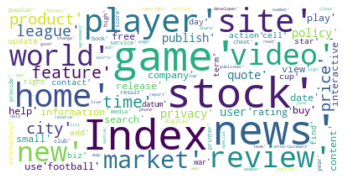

In [313]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str(words_most_frequent))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()#2

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



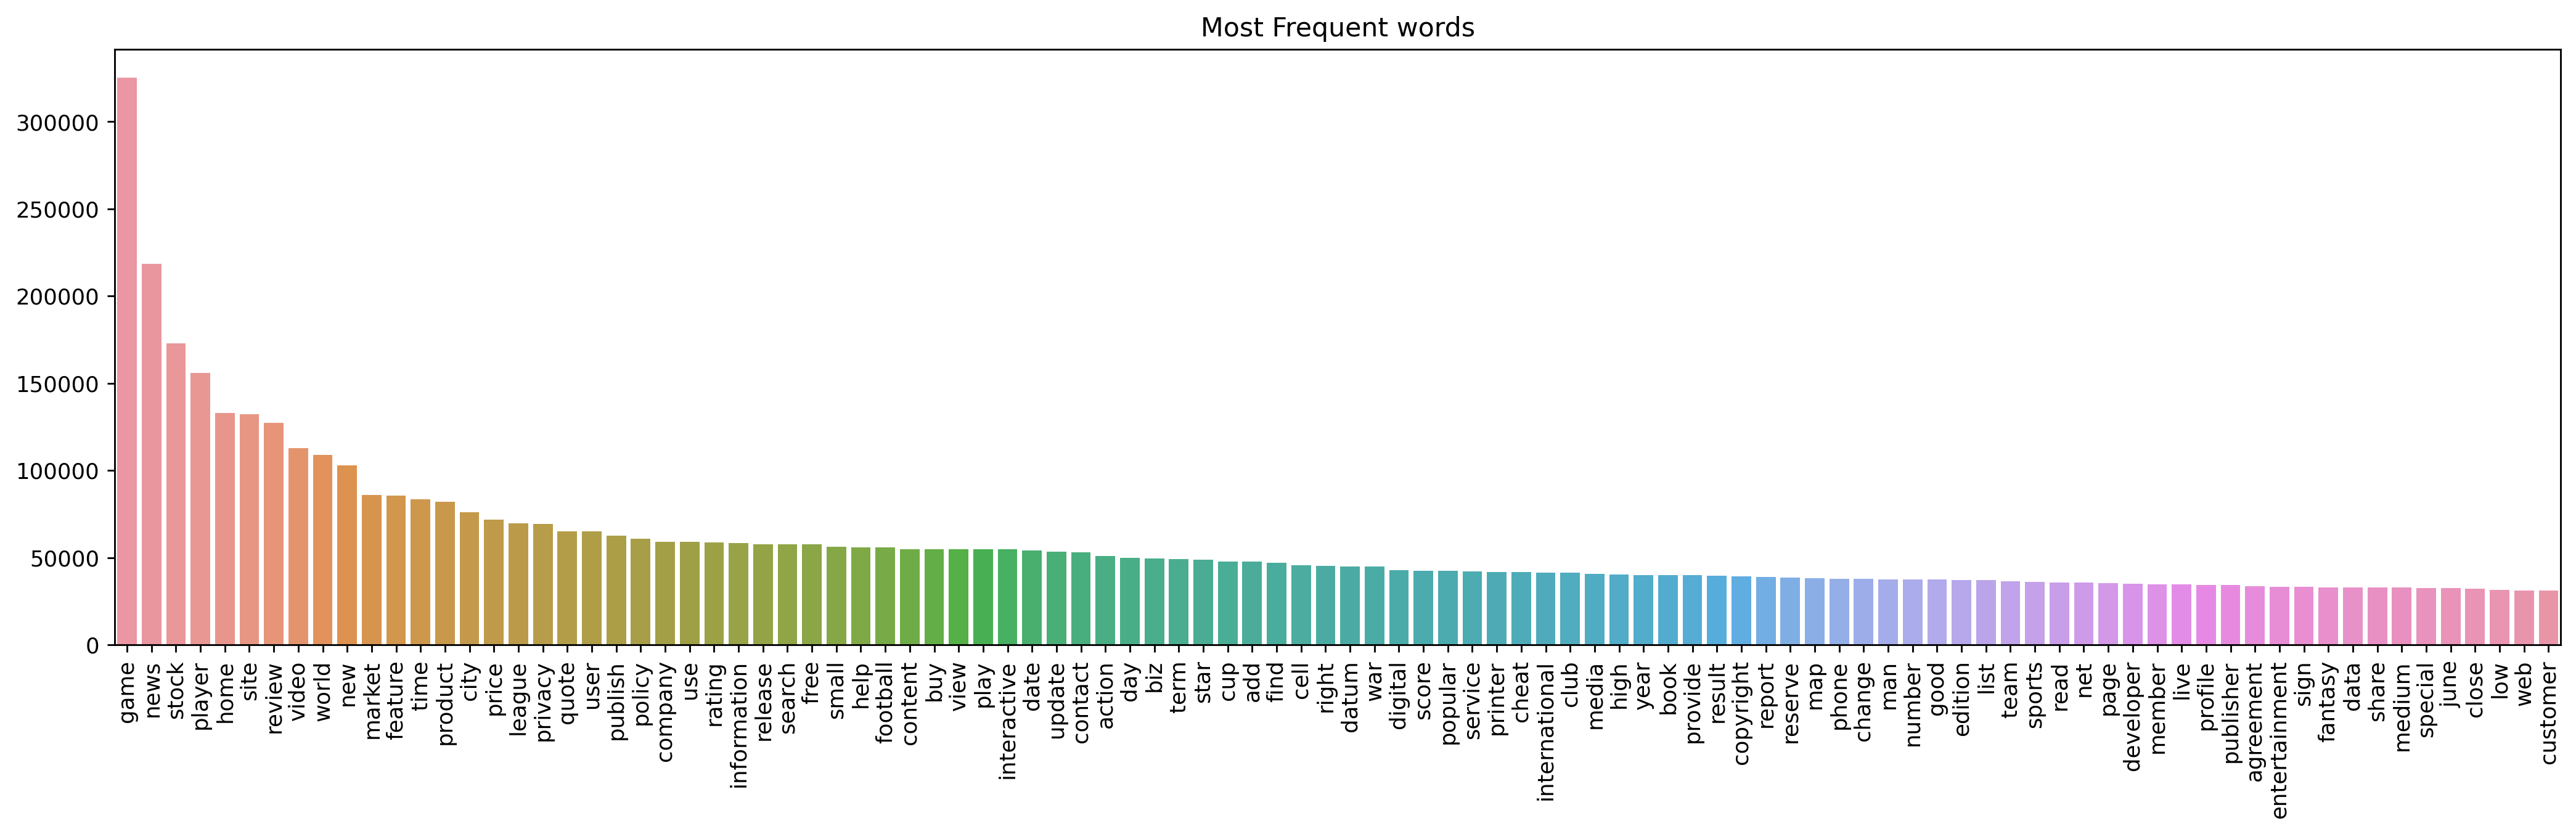

In [300]:
x = most_frequent.index
y = most_frequent
figure(num=None, figsize=(20,5), dpi=256, facecolor='w', edgecolor='r')
plt.title("Most Frequent words")
g=sns.barplot(x, y)
g.set_xticklabels(x,rotation=90) 
plt.show()

#### Provide examples of processed text (some parts)

Is everything all right with the result of cleaning these examples? What kind of information was lost?

In [301]:
cleaned_data_list=cleaned_data.values.tolist()

In [303]:
cleaned_data_list[0]

'eric love war eric love war author eric title love war copy copy available suggest short walk grain low gear recommend box recommendation topic war publish binding audio date publisher audio weight pound size x x inch edition abridge price previous giver previous moocher deb description book description peace summer allied pow eric walk away prison camp occupy camp line mountain help local evade retreat enemy peasant shelter month classic memoir recall selfless people unchanging funny bizarre dangerous incident hope local girl later wife exciting story superbly tell punch relate interest hood freedom available bot add save later web site relate edition recommend'

Since I am checking if the word is incloduded in the english dictionary, names are lost after processing the data.

# [10 points] Part 2. Duplicates detection. LSH

#### Libraries you can use

1. LSH - https://github.com/ekzhu/datasketch
1. LSH - https://github.com/mattilyra/LSH
1. Any other library on your choise

1. Detect duplicated text (duplicates do not imply a complete word-to-word match, but texts that may contain a paraphrase, rearrangement of words, sentences)
1. Make a plot dependency of duplicates on shingle size (with fixed minhash length) 
1. Make a plot dependency of duplicates on minhash length (with fixed shingle size)

In [6]:
# Open and Read the content of the CSV file into a dataframe
data_clean =pd.read_csv('processed.txt', delimiter = "\t", header=None)
data_clean.head()

,0
0,barnes NOBLE Respectable Trade Philippa Gregor...
1,BARNES NOBLE Wild Flowers Britian Europe W Lip...
2,barnes NOBLE Birds Britain Ireland Peter Holde...
3,BARNES NOBLE mushroom Toadstools Brian Spooner...
4,barnes NOBLE Wild Animals Britain Europe John ...


In [47]:
threshold = 0.5 # to be used when finding minhash

In [37]:
def find_shingles(text, ngram): # find different shingles for
    shingles=[]
    for i in range(0,len(text)):
        shingles.append(text[i:i+ngram])
    return set(shingles)

In [70]:
def lsh(data, ngrams, num_minhash, threshold):
    # replace each token by its shingles
    shingles = [find_shingles(row[0], ngrams) for row in data.values]
    # create minhash
    min_hashes = []
    for shingle in shingles:
        m_hash = MinHash(num_minhash)
        for element in shingle:
            m_hash.update(element.encode('utf-8'))
        min_hashes.append(m_hash)
    lsh = MinHashLSH(threshold, num_minhash)
    # insert minhash 
    for i, m in enumerate(min_hashes):
        lsh.insert(i, m)
    similarity = []
    for i, hash in enumerate(min_hashes):
        similar = lsh.query(hash)
        if i in similar:
            similar.remove(i) #removing the file itself
        similarity.extend(similar)
    return set(similarity)

###  different shingle size (with fixed minhash length) 

In [71]:
ngrams = [4, 16, 64, 128,256,512]
# fixed minhash length
ngram_results = []
for ngram in ngrams:
    result = lsh(data_clean[:1000], ngram, 128, threshold)
    ngram_results.append(len(result))

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



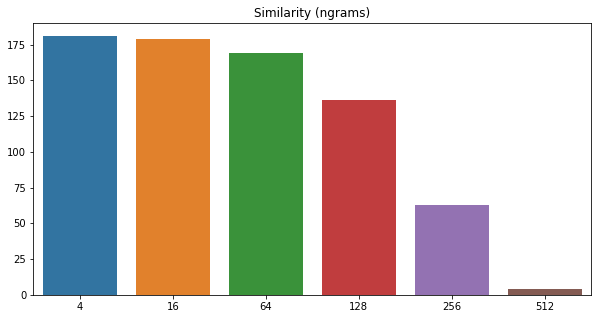

In [72]:
x = ngrams
y = ngram_results
figure(num=None, figsize=(10,5),  facecolor='w', edgecolor='r')
plt.title("Similarity (ngrams)")
g=sns.barplot(x, y)
g.set_xticklabels(x) 
plt.show()

###  different minhash length (with fixed shingle size) 

In [73]:
num_minhashs = [4, 16, 64, 128,256,512]
# fixed shingles length
num_minhash_result = []
for num_minhash in num_minhashs:
    result = lsh(data_clean[:1000], 128, num_minhash, threshold)
    num_minhash_result.append(len(result))

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



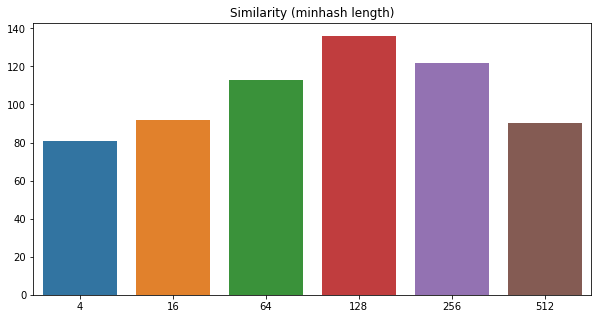

In [74]:
x = num_minhash
y = num_minhash_result
figure(num=None, figsize=(10,5),  facecolor='w', edgecolor='r')
plt.title("Similarity (minhash length)")
g=sns.barplot(x, y)
g.set_xticklabels(x) 
plt.show()